In [1]:
import torch
import numpy as np
import numba as nb
import cupy as cp
from numpy.typing import NDArray
from typing import Optional, Literal

import time
import matplotlib.pyplot as plt
from contextlib import contextmanager,ContextDecorator
import os
import inspect
import gc
import psutil
from functools import wraps

try:
    import pynvml
    HAS_NVML = True
except ImportError:
    HAS_NVML = False

class PerformanceMonitor:
    
    try:
        import pynvml
        HAS_NVML = True
    except ImportError:
        HAS_NVML = False
    
    def __init__(self):
        self.records = {}
        self._init_gpu()
        self.process = psutil.Process(os.getpid())
    
    def _init_gpu(self):
        """初始化GPU监控组件"""
        if self.HAS_NVML:
            try:
                pynvml.nvmlInit()
                self.gpu_handles = [pynvml.nvmlDeviceGetHandleByIndex(i) 
                                   for i in range(pynvml.nvmlDeviceGetCount())]
            except Exception as e:
                print(f"GPU监控不可用: {str(e)}")
                self.HAS_NVML = False
    
    def _clean_resources(self):
        """强制释放内存资源"""
        gc.collect()
        if self.HAS_NVML and hasattr(self, 'gpu_handles'):
            for handle in self.gpu_handles:
                try:
                    pynvml.nvmlDeviceSetDriverModel(handle, pynvml.NVML_DRIVER_MODEL_WDM)
                except:
                    pass
    
    def _get_cpu_mem(self):
        """获取当前进程内存使用(KB)"""
        return self.process.memory_info().rss // 1024
    
    def _get_gpu_mem(self):
        """获取显存使用量(Byte)"""
        if not self.HAS_NVML:
            return 0
        try:
            return sum(pynvml.nvmlDeviceGetMemoryInfo(handle).used 
                     for handle in self.gpu_handles)
        except:
            return 0
    
    @contextmanager
    def monitor(self, name=None):
        """上下文管理器实现"""
        self._clean_resources()
        start_time = time.time_ns()
        mem_start = self._get_cpu_mem()
        gpu_start = self._get_gpu_mem()
        
        try:
            yield
        finally:
            self._clean_resources()
            elapsed = (time.time_ns() - start_time) / 1e9
            mem_used = self._get_cpu_mem() - mem_start
            gpu_used = self._get_gpu_mem() - gpu_start
            
            func_name = name or inspect.currentframe().f_back.f_code.co_name
            self.records.setdefault(func_name, []).append({
                'time': elapsed,
                'memory': mem_used,
                'gpu_memory': gpu_used
            })
    
    def __call__(self, func=None, name=None):
        """装饰器实现"""
        if func is None:
            return lambda f: self(f, name=name)
        
        @wraps(func)
        def wrapper(*args, **kwargs):
            with self.monitor(name=name or func.__name__):
                return func(*args, **kwargs)
        
        return wrapper
    
    def show_results(self):
        """可视化展示结果（时间单位：秒）"""
        fig, axs = plt.subplots(3, 1, figsize=(12, 15))
        colors = plt.cm.plasma([i/len(self.records) for i in range(len(self.records))])

        for idx, (name, data) in enumerate(self.records.items()):
            avg_time = sum(d['time'] for d in data) / len(data)
            avg_mem = sum(d['memory'] for d in data) / len(data)
            avg_gpu = sum(d['gpu_memory'] for d in data) / len(data)

            # 修改时间单位部分
            time_label = f"{name}\n{avg_time:.3f}s"  # 保留3位小数
            mem_label = f"{name}\n{avg_mem:.1f}KB"
            gpu_label = f"{name}\n{avg_gpu/1e6:.2f}MB"

            # 绘制柱状图
            axs[0].bar(time_label, avg_time, color=colors[idx])
            axs[1].bar(mem_label, avg_mem, color=colors[idx])
            if any(d['gpu_memory'] for d in data):
                axs[2].bar(gpu_label, avg_gpu, color=colors[idx])

        # 调整图表标签
        axs[0].set_title('Average Execution Time (s)')  # 平均执行时间（秒）
        axs[1].set_title('Memory Increment (KB)')        # 内存增量（KB）
        axs[2].set_title('VRAM Usage (MB)')             # 显存增量（MB）
        
        # 优化时间轴显示
        axs[0].yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))  # Y轴保留3位小数
        plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
class Timer(ContextDecorator):
    
    def __init__(self, prefix="", name=None):
        """
        :param prefix: 自定义输出前缀
        :param name: 手动指定名称（最高优先级）
        """
        self.prefix = prefix
        self._name = name  # 用户手动指定的名称
        self.func_name = None
        
    def __enter__(self):
        # 优先使用手动指定的名称
        if self._name is not None:
            self.func_name = self._name
        else:
            # 自动获取调用栈中的名称
            stack = inspect.stack()
            for frame_info in stack[2:]:  # 跳过当前和 __enter__ 的栈帧
                frame = frame_info.frame
                co_name = frame.f_code.co_name
                if co_name not in ('<module>', 'wrapper', '<lambda>'):
                    self.func_name = co_name
                    break
            else:
                self.func_name = "Unknown"
        
        self.start_time = time.perf_counter()
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        elapsed = time.perf_counter() - self.start_time
        full_prefix = f"[{self.func_name}] {self.prefix}".strip()
        print(f"{full_prefix}耗时: {elapsed:.3f}秒")
        return False

    def __call__(self, func):
        # 装饰器模式下，默认使用被装饰函数名
        self.func_name = func.__name__
        return super().__call__(func)

def generate_test_data(n_ions=10000, n_ref=5000, n_adducts=5):
    """生成测试数据"""
    return (
        np.random.randn(n_ions).astype(np.float32),
        np.random.randn(n_ref, n_adducts).astype(np.float32)
    )

In [2]:
monitor = PerformanceMonitor()

@monitor
def get_fragments_hits_torch_cpu(
    qry_ions_array: np.ndarray,
    ref_fragment_mzs_array: np.ndarray,
    mz_tolerance: float = 3,
    mz_tolerance_type: Literal['ppm', 'Da'] = 'ppm',
    ref_RTs: Optional[np.ndarray] = None,
    query_RTs: Optional[np.ndarray] = None,
    RT_tolerance: float = 0.1,
    adduct_co_occurrence_threshold: int = 1,
    ref_offset: int = 0,
    qry_offset: int = 0,
) -> np.ndarray:

    device = torch.device('cpu')

    with torch.no_grad(), Timer("总耗时","get_fragments_hits_torch_cpu"):
        # 张量转换计时
        with Timer("张量转换","get_fragments_hits_torch_cpu"):
            qry = torch.as_tensor(qry_ions_array, dtype=torch.float32, device=device)
            ref = torch.as_tensor(ref_fragment_mzs_array, dtype=torch.float32, device=device)

        # Delta计算计时
        with Timer("Delta计算","get_fragments_hits_torch_cpu"):
            delta = torch.abs(qry.view(-1, 1, 1) - ref.view(1, -1, ref.size(1)))
            if mz_tolerance_type == 'ppm':
                delta = torch.mul(delta, (1e6 / ref.view(1, -1, ref.size(1))), out=delta)

        # 质量过滤计时
        with Timer("质量过滤","get_fragments_hits_torch_cpu"):
            mz_mask = torch.le(delta, mz_tolerance, out=delta)
            del delta

        # RT过滤计时
        if ref_RTs is not None and query_RTs is not None:
            with Timer("RT过滤","get_fragments_hits_torch_cpu"):
                rt_q = torch.as_tensor(query_RTs, dtype=torch.float16, device=device)
                rt_r = torch.as_tensor(ref_RTs, dtype=torch.float16, device=device)
                rt_mask = torch.le(
                    torch.abs(rt_q.view(-1, 1) - rt_r.view(1, -1)), 
                    RT_tolerance,
                    out=rt_q
                )
                mz_mask = torch.mul(mz_mask, rt_mask.view(rt_mask.size(0), rt_mask.size(1), 1))
                del rt_mask

        # 加合物过滤计时
        if adduct_co_occurrence_threshold > 1:
            with Timer("加合物过滤","get_fragments_hits_torch_cpu"):
                valid_refs = torch.sum(
                    torch.any(mz_mask, dim=0, keepdim=True), 
                    dim=2, 
                    keepdim=True
                ) >= adduct_co_occurrence_threshold
                mz_mask = torch.mul(mz_mask, valid_refs)

        # 结果收集计时
        with Timer("结果收集","get_fragments_hits_torch_cpu"):
            nonzero_indices = torch.nonzero(mz_mask)
            if qry_offset > 0 or ref_offset > 0:
                nonzero_indices[:, 0] += qry_offset
                nonzero_indices[:, 1] += ref_offset
                
        with Timer("张量转换","get_fragments_hits_torch_cpu"):
            nonzero_indices = nonzero_indices.cpu().numpy().astype(np.uint32)

        return nonzero_indices

@monitor
def get_fragments_hits_torch_gpu(
    qry_ions_array: np.ndarray,           # shape: (n_ions,) np.float32
    ref_fragment_mzs_array: np.ndarray,   # shape: (n_ref, n_adducts) np.float32
    mz_tolerance: float = 3,
    mz_tolerance_type: Literal['ppm', 'Da'] = 'ppm',
    ref_RTs: Optional[np.ndarray] = None,  # shape: (n_ref,) np.float16
    query_RTs: Optional[np.ndarray] = None,# shape: (n_ions,) np.float16
    RT_tolerance: float = 0.1,
    adduct_co_occurrence_threshold: int = 1,
    ref_offset: int = 0,
    qry_offset: int = 0,
) -> np.ndarray:
    """极致优化的 PyTorch GPU 版本，返回形状为 (n_hits, 3) 的 uint32 数组"""
    
    device = torch.device('cuda:1')
    
    # 总耗时监控
    with Timer("总耗时","get_fragments_hits_torch_gpu"), torch.no_grad():
        # 张量转换计时
        with Timer("张量转换","get_fragments_hits_torch_gpu"):
            qry = torch.as_tensor(qry_ions_array, dtype=torch.float32, device=device)
            ref = torch.as_tensor(ref_fragment_mzs_array, dtype=torch.float32, device=device)

        # 质量差异计算
        with Timer("Delta计算","get_fragments_hits_torch_gpu"):
            delta = torch.abs(qry.view(-1, 1, 1) - ref.view(1, -1, ref.size(1)))
            if mz_tolerance_type == 'ppm':
                delta = torch.mul(delta, (1e6 / ref.view(1, -1, ref.size(1))), out=delta)

        # 质量过滤
        with Timer("质量过滤","get_fragments_hits_torch_gpu"):
            mz_mask = torch.le(delta, mz_tolerance, out=delta)
            del delta  # 显存释放计入当前计时块

        # RT过滤（条件分支）
        if ref_RTs is not None and query_RTs is not None:
            with Timer("RT过滤","get_fragments_hits_torch_gpu"):
                rt_q = torch.as_tensor(query_RTs, dtype=torch.float16, device=device)
                rt_r = torch.as_tensor(ref_RTs, dtype=torch.float16, device=device)
                rt_mask = torch.le(
                    torch.abs(rt_q.view(-1, 1) - rt_r.view(1, -1)), 
                    RT_tolerance,
                    out=rt_q
                )
                mz_mask = torch.mul(mz_mask, rt_mask.view(rt_mask.size(0), rt_mask.size(1), 1))
                del rt_mask

        # 加合物过滤（条件分支）
        if adduct_co_occurrence_threshold > 1:
            with Timer("加合物过滤","get_fragments_hits_torch_gpu"):
                valid_refs = torch.sum(
                    torch.any(mz_mask, dim=0, keepdim=True), 
                    dim=2, 
                    keepdim=True
                ) >= adduct_co_occurrence_threshold
                mz_mask = torch.mul(mz_mask, valid_refs)

        # 结果收集
        with Timer("结果收集","get_fragments_hits_torch_gpu"):
            nonzero_indices = torch.nonzero(mz_mask)
            if qry_offset > 0 or ref_offset > 0:
                nonzero_indices[:, 0] += qry_offset
                nonzero_indices[:, 1] += ref_offset
                
        with Timer("张量转换","get_fragments_hits_torch_gpu"):
            nonzero_indices = nonzero_indices.cpu().numpy().astype(np.uint32)

        return nonzero_indices

@monitor
def get_fragments_hits_torch_gpu_native(
    qry_ions_array: NDArray[np.float32],
    ref_fragment_mzs_array: NDArray[np.float32],
    mz_tolerance: float = 3,
    mz_tolerance_type: Literal['ppm', 'Da'] = 'ppm',
    ref_RTs: Optional[NDArray[np.float16]] = None,
    query_RTs: Optional[NDArray[np.float16]] = None,
    RT_tolerance: float = 0.1,
    adduct_co_occurrence_threshold: int = 1,
    ref_offset: int = 0,
    qry_offset: int = 0,
) -> np.ndarray:
    """PyTorch GPU版本，返回形状为(n_hits, 3)的uint32数组"""
    
    device = torch.device('cuda:1')
    
    with torch.no_grad():
        # 张量转换
        with Timer("张量转换", "get_fragments_hits_torch_gpu_native"):
            qry = torch.as_tensor(qry_ions_array, dtype=torch.float32, device=device)
            ref = torch.as_tensor(ref_fragment_mzs_array, dtype=torch.float32, device=device)

        # Delta计算
        with Timer("Delta计算", "get_fragments_hits_torch_gpu_native"):
            delta = torch.abs(qry[:, None, None] - ref[None, :, :])
            if mz_tolerance_type == 'ppm':
                delta = delta * (1e6 / ref[None, :, :])

        # 质量过滤
        with Timer("质量过滤", "get_fragments_hits_torch_gpu_native"):
            mz_mask = delta <= mz_tolerance
            del delta

        # RT过滤（条件分支）
        if ref_RTs is not None and query_RTs is not None:
            with Timer("RT过滤", "get_fragments_hits_torch_gpu_native"):
                rt_q = torch.as_tensor(query_RTs, dtype=torch.float16, device=device)
                rt_r = torch.as_tensor(ref_RTs, dtype=torch.float16, device=device)
                rt_mask = torch.abs(rt_q[:, None] - rt_r[None, :]) <= RT_tolerance
                mz_mask = mz_mask * rt_mask[:, :, None]

        # 加合物过滤（条件分支）
        if adduct_co_occurrence_threshold > 1:
            with Timer("加合物过滤", "get_fragments_hits_torch_gpu_native"):
                adduct_counts = mz_mask.any(dim=0).sum(dim=1)
                valid_refs = adduct_counts >= adduct_co_occurrence_threshold
                mz_mask = mz_mask * valid_refs[None, :, None]

        # 结果收集
        with Timer("结果收集", "get_fragments_hits_torch_gpu_native"):
            indices = torch.nonzero(mz_mask)
            indices[:, 0] += qry_offset
            indices[:, 1] += ref_offset

        # 数据回传
        with Timer("张量转换", "get_fragments_hits_torch_gpu_native"):
            result = indices.cpu().numpy().astype(np.uint32)

    return result

@monitor
def get_fragments_hits_torch_gpu_optimized(
    qry_ions_array: np.ndarray,           # shape: (n_ions,) np.float32
    ref_fragment_mzs_array: np.ndarray,   # shape: (n_ref, n_adducts) np.float32
    mz_tolerance: float = 3,
    mz_tolerance_type: Literal['ppm', 'Da'] = 'ppm',
    ref_RTs: Optional[np.ndarray] = None,  # shape: (n_ref,) np.float16
    query_RTs: Optional[np.ndarray] = None,# shape: (n_ions,) np.float16
    RT_tolerance: float = 0.1,
    adduct_co_occurrence_threshold: int = 1,
    ref_offset: int = 0,
    qry_offset: int = 0,
) -> np.ndarray:
    """极致优化的无分块GPU版本"""
    
    # 总耗时监控
    with Timer("总耗时", "get_fragments_hits_torch_gpu_optimized"):
        device = torch.device('cuda:0')

        # ========== 内存预处理优化 ==========
        with Timer("内存预处理", "get_fragments_hits_torch_gpu_optimized"):
            qry_np = np.ascontiguousarray(qry_ions_array, dtype=np.float32)
            ref_np = np.ascontiguousarray(ref_fragment_mzs_array, dtype=np.float32)

        # ========== 异步流式传输 ==========
        stream = torch.cuda.Stream()
        with torch.cuda.stream(stream), \
             torch.no_grad(), \
             torch.autocast(device_type='cuda', dtype=torch.float16):

            # 张量传输优化
            with Timer("异步传输", "get_fragments_hits_torch_gpu_optimized"):
                qry = torch.as_tensor(qry_np, device=device)
                ref = torch.as_tensor(ref_np, device=device)

            # ========== 核心计算优化 ==========
            with Timer("爱因斯坦求和", "get_fragments_hits_torch_gpu_optimized"):
                delta = torch.abs(torch.einsum('i,jk->ijk', qry, torch.ones_like(ref)) - ref)

            # 原位缩放优化
            with Timer("ppm转换", "get_fragments_hits_torch_gpu_optimized") if mz_tolerance_type == 'ppm' else dummy_context():
                if mz_tolerance_type == 'ppm':
                    delta.div_(ref).mul_(1e6)

            # 掩码生成优化
            with Timer("掩码生成", "get_fragments_hits_torch_gpu_optimized"):
                mask = torch.le(delta, mz_tolerance, out=delta)
                del delta

            # ========== RT条件处理 ==========
            if ref_RTs is not None and query_RTs is not None:
                with Timer("RT处理", "get_fragments_hits_torch_gpu_optimized"):
                    rt_diff = torch.abs(
                        torch.as_tensor(query_RTs, device=device, dtype=torch.float16)[:, None] - 
                        torch.as_tensor(ref_RTs, device=device, dtype=torch.float16)
                    )
                    rt_mask = torch.le(rt_diff, RT_tolerance)
                    mask &= rt_mask[..., None]

            # ========== 加合物条件优化 ==========
            if adduct_co_occurrence_threshold > 1:
                with Timer("加合物过滤", "get_fragments_hits_torch_gpu_optimized"):
                    valid_refs = torch.sum(mask.any(dim=0), dim=1) >= adduct_co_occurrence_threshold
                    mask &= valid_refs[None, :, None]

            # ========== 稀疏索引优化 ==========
            with Timer("稀疏转换", "get_fragments_hits_torch_gpu_optimized"):
                sparse_mask = mask.to_sparse_coo().coalesce()
                indices = sparse_mask.indices()

            # 偏移应用优化
            with Timer("偏移处理", "get_fragments_hits_torch_gpu_optimized"):
                indices[0] += qry_offset
                indices[1] += ref_offset

        # ========== 异步流同步 ==========
        with Timer("流同步", "get_fragments_hits_torch_gpu_optimized"):
            torch.cuda.synchronize(device=device)

        # 零拷贝回传优化
        with Timer("结果回传", "get_fragments_hits_torch_gpu_optimized"):
            return indices.t().cpu().numpy().astype(np.uint32)

@monitor
def get_fragments_hits_cupy(
    qry_ions_array: NDArray[np.float32],           # shape: (n_ions,) np.float32
    ref_fragment_mzs_array: NDArray[np.float32],   # shape: (n_ref, n_adducts) np.float32
    mz_tolerance: float = 3,
    mz_tolerance_type: Literal['ppm', 'Da'] = 'ppm',
    ref_RTs: Optional[NDArray[np.float16]] = None,  # shape: (n_ref,) np.float16
    query_RTs: Optional[NDArray[np.float16]] = None,# shape: (n_ions,) np.float16
    RT_tolerance: float = 0.1,
    adduct_co_occurrence_threshold: int = 1,
    ref_offset: int = 0,
    qry_offset: int = 0,
) -> np.ndarray:
    """GPU 加速版本，返回形状为 (n_hits, 3) 的 uint32 数组"""
    
    # 总耗时监控
    with Timer("总耗时", "get_fragments_hits_cupy"):
        # 数据传输到GPU
        with Timer("数据传输到GPU", "get_fragments_hits_cupy"):
            qry_gpu = cp.asarray(qry_ions_array, dtype=cp.float32)
            ref_gpu = cp.asarray(ref_fragment_mzs_array, dtype=cp.float32)

        # 质量差异计算
        with Timer("m/z差异计算", "get_fragments_hits_cupy"):
            delta = cp.abs(qry_gpu[:, None, None] - ref_gpu[None, :, :])

        # 容差转换处理
        if mz_tolerance_type == 'ppm':
            with Timer("ppm转换", "get_fragments_hits_cupy"):
                delta = delta * (1e6 / ref_gpu[None, :, :])

        # 质量过滤
        with Timer("质量过滤", "get_fragments_hits_cupy"):
            mz_mask = delta <= mz_tolerance
            del delta  # 显存释放计入当前计时块

        # RT条件处理
        if ref_RTs is not None and query_RTs is not None:
            with Timer("RT过滤", "get_fragments_hits_cupy"):
                rt_gpu = cp.abs(cp.asarray(query_RTs)[:, None] - cp.asarray(ref_RTs)[None, :])
                rt_mask = rt_gpu <= RT_tolerance
                mz_mask = mz_mask * rt_mask[:, :, None]
                del rt_gpu, rt_mask

        # 加合物阈值处理
        if adduct_co_occurrence_threshold > 1:
            with Timer("加合物过滤", "get_fragments_hits_cupy"):
                adduct_counts = mz_mask.any(axis=0).sum(axis=1)
                valid_refs = adduct_counts >= adduct_co_occurrence_threshold
                mz_mask = mz_mask * valid_refs[None, :, None]

        # 结果收集与处理
        with Timer("结果收集", "get_fragments_hits_cupy"):
            qry_idx, ref_idx, adduct_idx = cp.where(mz_mask)
            result = cp.stack([
                qry_idx + qry_offset,
                ref_idx + ref_offset,
                adduct_idx
            ], axis=1).astype(cp.uint32)

        # 数据回传
        with Timer("数据回传", "get_fragments_hits_cupy"):
            return result.get()

@monitor
@nb.njit(nogil=True)
def get_fragments_hits_numba(
    qry_ions_array: NDArray[np.float32],
    ref_fragment_mzs_array: NDArray[np.float32],
    mz_tolerance: float = 3,
    mz_tolerance_type: Literal['ppm', 'Da'] = 'ppm',
    ref_RTs: Optional[NDArray[np.float16]] = None,
    query_RTs: Optional[NDArray[np.float16]] = None,
    RT_tolerance: float = 0.1,
    adduct_co_occurrence_threshold: int = 1,
    ref_offset: int = 0,
    qry_offset: int = 0,
) -> NDArray[np.uint32]:
    # 计算绝对m/z差
    IDF_matrix = np.abs(qry_ions_array[:, np.newaxis, np.newaxis] - ref_fragment_mzs_array[np.newaxis, :, :])
    
    # 处理ppm容差
    if mz_tolerance_type == 'ppm':
        IDF_matrix *= 1e6 / ref_fragment_mzs_array[np.newaxis, :, :]
    
    # 生成布尔矩阵
    IDF_matrix = np.less_equal(IDF_matrix, mz_tolerance)
    
    # 处理RT容差
    if ref_RTs is not None and query_RTs is not None:
        RT_matrix = np.abs(query_RTs[:, np.newaxis] - ref_RTs[np.newaxis, :])
        RT_matrix = np.less_equal(RT_matrix, RT_tolerance)
        IDF_matrix *= RT_matrix[:, :, np.newaxis]  # 删除del语句
    
    # 应用加合物共现阈值
    if adduct_co_occurrence_threshold > 1:
        valid_refs = (IDF_matrix.sum(axis=0).sum(axis=1) >= adduct_co_occurrence_threshold)
        IDF_matrix *= valid_refs[np.newaxis, :, np.newaxis]
    
    # 获取命中索引
    qry_index, ref_index, adduct_index = np.where(IDF_matrix)
    
    # 应用偏移量
    qry_index += qry_offset
    ref_index += ref_offset
    
    # 返回堆叠结果
    return np.column_stack((qry_index, ref_index, adduct_index)).astype(np.uint32)

@monitor
def get_fragments_hits_numpy(
    qry_ions_array: NDArray[np.float32],
    ref_fragment_mzs_array: NDArray[np.float32],
    mz_tolerance: float = 3,
    mz_tolerance_type: Literal['ppm', 'Da'] = 'ppm',
    ref_RTs: Optional[NDArray[np.float16]] = None,
    query_RTs: Optional[NDArray[np.float16]] = None,
    RT_tolerance: float = 0.1,
    adduct_co_occurrence_threshold: int = 1,
    ref_offset: int = 0,
    qry_offset: int = 0,
) -> NDArray[np.uint32]:
    
    with Timer("总耗时", "get_fragments_hits_numpy"):
        # ========== 质量差异计算 ==========
        with Timer("m/z差异计算", "get_fragments_hits_numpy"):
            IDF_matrix = np.abs(qry_ions_array[:, np.newaxis, np.newaxis] - 
                              ref_fragment_mzs_array[np.newaxis, :, :])

        # ========== 容差类型处理 ==========
        if mz_tolerance_type == 'ppm':
            with Timer("ppm转换", "get_fragments_hits_numpy"):
                IDF_matrix *= 1e6 / ref_fragment_mzs_array[np.newaxis, :, :]

        # ========== 布尔矩阵生成 ==========
        with Timer("布尔矩阵生成", "get_fragments_hits_numpy"):
            IDF_matrix = np.less_equal(IDF_matrix, mz_tolerance)

        # ========== RT条件处理 ==========
        if ref_RTs is not None and query_RTs is not None:
            with Timer("RT容差处理", "get_fragments_hits_numpy"):
                RT_matrix = np.abs(query_RTs[:, np.newaxis] - ref_RTs[np.newaxis, :])
                RT_matrix = np.less_equal(RT_matrix, RT_tolerance)
                IDF_matrix *= RT_matrix[:, :, np.newaxis]

        # ========== 加合物阈值处理 ==========
        if adduct_co_occurrence_threshold > 1:
            with Timer("加合物阈值应用", "get_fragments_hits_numpy"):
                valid_refs = (IDF_matrix.sum(axis=0).sum(axis=1) >= adduct_co_occurrence_threshold)
                IDF_matrix *= valid_refs[np.newaxis, :, np.newaxis]

        # ========== 索引收集处理 ==========
        with Timer("索引收集", "get_fragments_hits_numpy"):
            qry_index, ref_index, adduct_index = np.where(IDF_matrix)

        # ========== 偏移量应用 ==========
        with Timer("偏移量应用", "get_fragments_hits_numpy"):
            qry_index += qry_offset
            ref_index += ref_offset

        # ========== 结果格式化 ==========
        with Timer("结果堆叠转换", "get_fragments_hits_numpy"):
            return np.column_stack((qry_index, ref_index, adduct_index)).astype(np.uint32)

In [3]:
qry, ref = generate_test_data(5000,5000,5)

In [4]:
qry_torch = torch.tensor(qry, dtype=torch.float32).cuda()
ref_torch = torch.tensor(ref, dtype=torch.float32).cuda()

In [5]:
qry_cupy = cp.asarray(qry, dtype=cp.float32)
ref_cupy = cp.asarray(ref, dtype=cp.float32)

In [6]:
monitor = PerformanceMonitor()

@monitor
def get_fragments_hits_torch_gpu_by_tensor(
    qry_ions_array: NDArray[np.float32],
    ref_fragment_mzs_array: NDArray[np.float32],
    mz_tolerance: float = 3,
    mz_tolerance_type: Literal['ppm', 'Da'] = 'ppm',
    ref_RTs: Optional[NDArray[np.float16]] = None,
    query_RTs: Optional[NDArray[np.float16]] = None,
    RT_tolerance: float = 0.1,
    adduct_co_occurrence_threshold: int = 1,
    ref_offset: int = 0,
    qry_offset: int = 0,
) -> np.ndarray:
    """PyTorch GPU版本，返回形状为(n_hits, 3)的uint32数组"""
    
    device = torch.device('cuda:1')
    
    with torch.no_grad():
        if not isinstance(qry_ions_array, torch.Tensor):
            # 张量转换
            with Timer("张量转换", "get_fragments_hits_torch_gpu_native"):
                qry = torch.as_tensor(qry_ions_array, dtype=torch.float32, device=device)
                ref = torch.as_tensor(ref_fragment_mzs_array, dtype=torch.float32, device=device)
        else:
            qry = qry_ions_array
            ref = ref_fragment_mzs_array

        # Delta计算
        with Timer("Delta计算", "get_fragments_hits_torch_gpu_native"):
            delta = torch.abs(qry[:, None, None] - ref[None, :, :])
            if mz_tolerance_type == 'ppm':
                delta = delta * (1e6 / ref[None, :, :])

        # 质量过滤
        with Timer("质量过滤", "get_fragments_hits_torch_gpu_native"):
            mz_mask = delta <= mz_tolerance
            del delta

        # RT过滤（条件分支）
        if ref_RTs is not None and query_RTs is not None:
            with Timer("RT过滤", "get_fragments_hits_torch_gpu_native"):
                rt_q = torch.as_tensor(query_RTs, dtype=torch.float16, device=device)
                rt_r = torch.as_tensor(ref_RTs, dtype=torch.float16, device=device)
                rt_mask = torch.abs(rt_q[:, None] - rt_r[None, :]) <= RT_tolerance
                mz_mask = mz_mask * rt_mask[:, :, None]

        # 加合物过滤（条件分支）
        if adduct_co_occurrence_threshold > 1:
            with Timer("加合物过滤", "get_fragments_hits_torch_gpu_native"):
                adduct_counts = mz_mask.any(dim=0).sum(dim=1)
                valid_refs = adduct_counts >= adduct_co_occurrence_threshold
                mz_mask = mz_mask * valid_refs[None, :, None]

        # 结果收集
        with Timer("结果收集", "get_fragments_hits_torch_gpu_native"):
            indices = torch.nonzero(mz_mask)
            indices[:, 0] += qry_offset
            indices[:, 1] += ref_offset

        # # 数据回传
        # with Timer("张量转换", "get_fragments_hits_torch_gpu_native"):
        #     result = indices.cpu().numpy().astype(np.uint32)

    return indices

@monitor
def get_fragments_hits_cupy_by_cupy(
    qry_ions_array: NDArray[np.float32],           # shape: (n_ions,) np.float32
    ref_fragment_mzs_array: NDArray[np.float32],   # shape: (n_ref, n_adducts) np.float32
    mz_tolerance: float = 3,
    mz_tolerance_type: Literal['ppm', 'Da'] = 'ppm',
    ref_RTs: Optional[NDArray[np.float16]] = None,  # shape: (n_ref,) np.float16
    query_RTs: Optional[NDArray[np.float16]] = None,# shape: (n_ions,) np.float16
    RT_tolerance: float = 0.1,
    adduct_co_occurrence_threshold: int = 1,
    ref_offset: int = 0,
    qry_offset: int = 0,
) -> np.ndarray:
    """GPU 加速版本，返回形状为 (n_hits, 3) 的 uint32 数组"""
    
    # 总耗时监控
    with Timer("总耗时", "get_fragments_hits_cupy"):
        # 数据传输到GPU
        if not isinstance(qry_ions_array, cp.ndarray):
            with Timer("数据传输到GPU", "get_fragments_hits_cupy"):
                qry_gpu = cp.asarray(qry_ions_array, dtype=cp.float32)
                ref_gpu = cp.asarray(ref_fragment_mzs_array, dtype=cp.float32)
        else:
            qry_gpu = qry_ions_array
            ref_gpu = ref_fragment_mzs_array

        # 质量差异计算
        with Timer("m/z差异计算", "get_fragments_hits_cupy"):
            delta = cp.abs(qry_gpu[:, None, None] - ref_gpu[None, :, :])

        # 容差转换处理
        if mz_tolerance_type == 'ppm':
            with Timer("ppm转换", "get_fragments_hits_cupy"):
                delta = delta * (1e6 / ref_gpu[None, :, :])

        # 质量过滤
        with Timer("质量过滤", "get_fragments_hits_cupy"):
            mz_mask = delta <= mz_tolerance
            del delta  # 显存释放计入当前计时块

        # RT条件处理
        if ref_RTs is not None and query_RTs is not None:
            with Timer("RT过滤", "get_fragments_hits_cupy"):
                rt_gpu = cp.abs(cp.asarray(query_RTs)[:, None] - cp.asarray(ref_RTs)[None, :])
                rt_mask = rt_gpu <= RT_tolerance
                mz_mask = mz_mask * rt_mask[:, :, None]
                del rt_gpu, rt_mask

        # 加合物阈值处理
        if adduct_co_occurrence_threshold > 1:
            with Timer("加合物过滤", "get_fragments_hits_cupy"):
                adduct_counts = mz_mask.any(axis=0).sum(axis=1)
                valid_refs = adduct_counts >= adduct_co_occurrence_threshold
                mz_mask = mz_mask * valid_refs[None, :, None]

        # 结果收集与处理
        with Timer("结果收集", "get_fragments_hits_cupy"):
            qry_idx, ref_idx, adduct_idx = cp.where(mz_mask)
            result = cp.stack([
                qry_idx + qry_offset,
                ref_idx + ref_offset,
                adduct_idx
            ], axis=1).astype(cp.uint32)
            
        return result
            
        # # 数据回传
        # with Timer("数据回传", "get_fragments_hits_cupy"):
        #     return result.get()

In [7]:
results = get_fragments_hits_torch_gpu_by_tensor(qry_torch,ref_torch)
del results
results = get_fragments_hits_cupy_by_cupy(qry_cupy,ref_cupy)
del results
results = get_fragments_hits_cupy_by_cupy(qry_torch,ref_torch)
del results

[get_fragments_hits_torch_gpu_native] Delta计算耗时: 0.032秒
[get_fragments_hits_torch_gpu_native] 质量过滤耗时: 0.006秒
[get_fragments_hits_torch_gpu_native] 结果收集耗时: 0.005秒
[get_fragments_hits_cupy] m/z差异计算耗时: 0.085秒
[get_fragments_hits_cupy] ppm转换耗时: 0.002秒
[get_fragments_hits_cupy] 质量过滤耗时: 0.001秒
[get_fragments_hits_cupy] 结果收集耗时: 0.021秒
[get_fragments_hits_cupy] 总耗时耗时: 0.109秒
[get_fragments_hits_cupy] 数据传输到GPU耗时: 0.000秒
[get_fragments_hits_cupy] m/z差异计算耗时: 0.000秒
[get_fragments_hits_cupy] ppm转换耗时: 0.000秒
[get_fragments_hits_cupy] 质量过滤耗时: 0.000秒
[get_fragments_hits_cupy] 结果收集耗时: 0.005秒
[get_fragments_hits_cupy] 总耗时耗时: 0.005秒


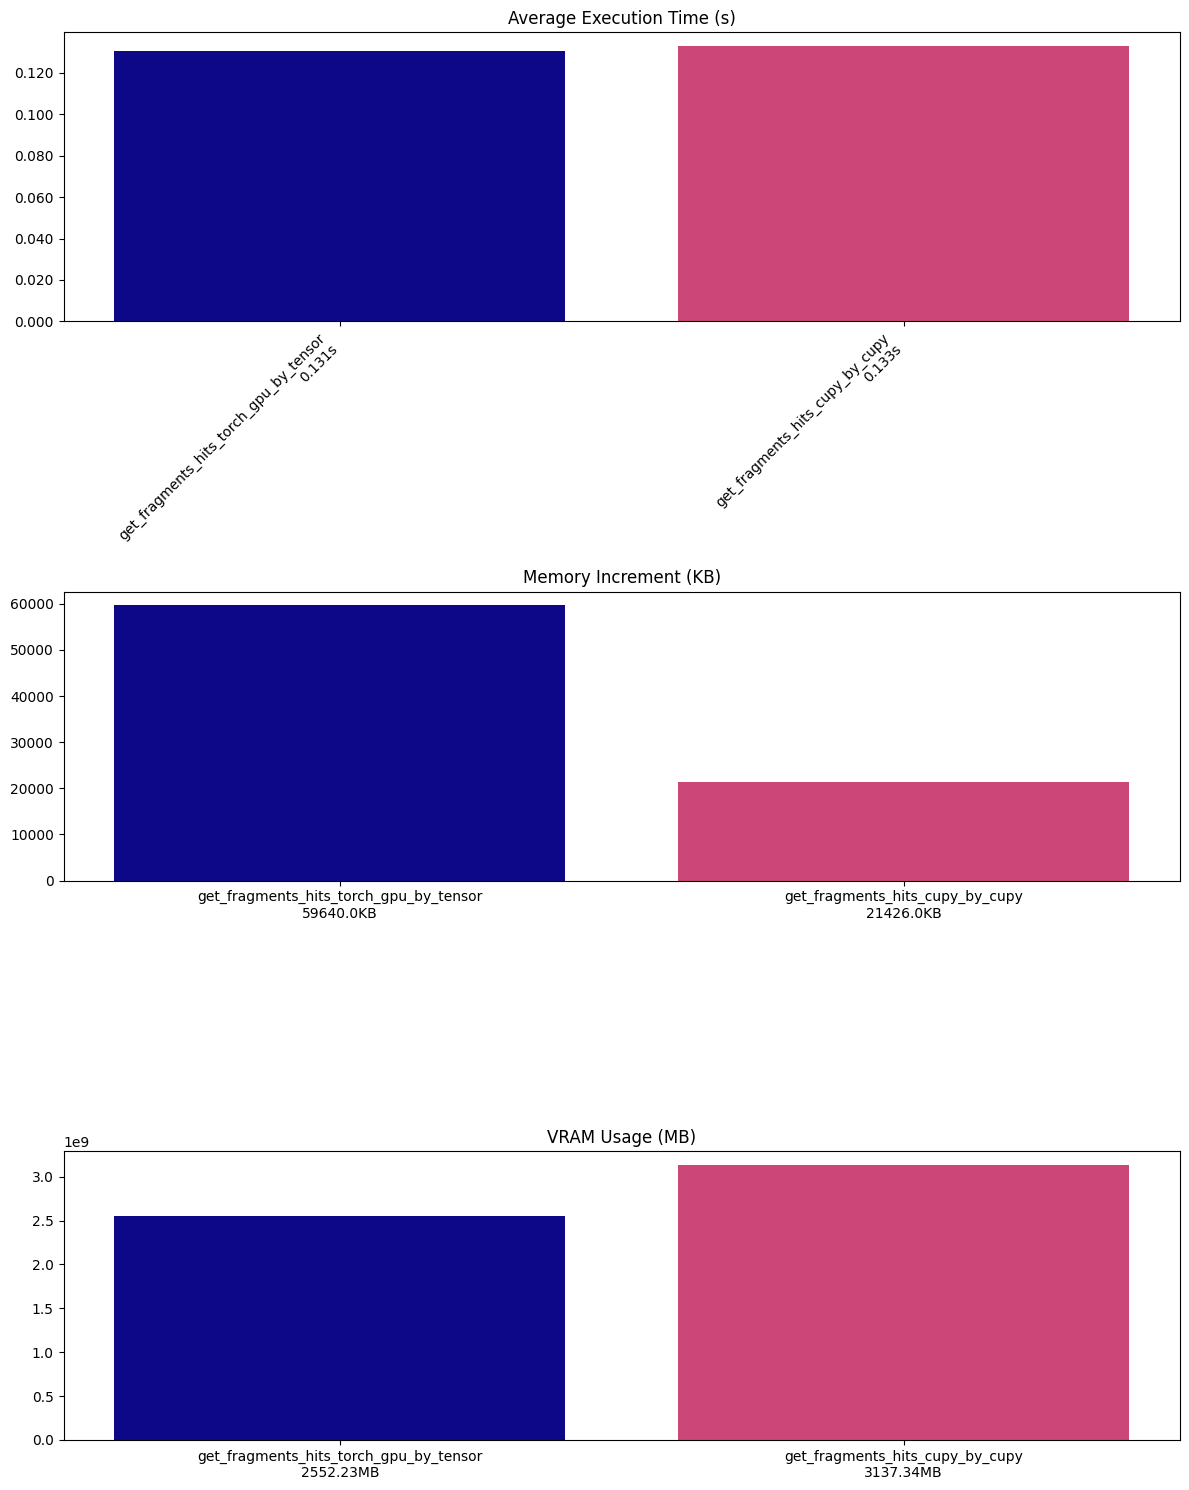

In [8]:
monitor.show_results()

In [4]:
results = get_fragments_hits_numpy(qry,ref)
del results
# results = get_fragments_hits_numba(qry,ref)
# del results
results = get_fragments_hits_cupy(qry,ref)
del results
results = get_fragments_hits_torch_gpu(qry,ref)
del results
results = get_fragments_hits_torch_gpu_native(qry,ref)
del results
results = get_fragments_hits_torch_gpu_optimized(qry,ref)
del results
results = get_fragments_hits_torch_cpu(qry,ref)
del results

[get_fragments_hits_numpy] m/z差异计算耗时: 0.317秒
[get_fragments_hits_numpy] ppm转换耗时: 0.043秒
[get_fragments_hits_numpy] 布尔矩阵生成耗时: 0.070秒
[get_fragments_hits_numpy] 索引收集耗时: 1.290秒
[get_fragments_hits_numpy] 偏移量应用耗时: 0.246秒
[get_fragments_hits_numpy] 结果堆叠转换耗时: 1.300秒
[get_fragments_hits_numpy] 总耗时耗时: 3.265秒
[get_fragments_hits_cupy] 数据传输到GPU耗时: 0.129秒
[get_fragments_hits_cupy] m/z差异计算耗时: 0.085秒
[get_fragments_hits_cupy] ppm转换耗时: 0.002秒
[get_fragments_hits_cupy] 质量过滤耗时: 0.001秒
[get_fragments_hits_cupy] 结果收集耗时: 0.021秒
[get_fragments_hits_cupy] 数据回传耗时: 0.373秒
[get_fragments_hits_cupy] 总耗时耗时: 0.611秒
[get_fragments_hits_torch_gpu] 张量转换耗时: 0.098秒
[get_fragments_hits_torch_gpu] Delta计算耗时: 0.032秒
[get_fragments_hits_torch_gpu] 质量过滤耗时: 0.007秒
[get_fragments_hits_torch_gpu] 结果收集耗时: 0.025秒
[get_fragments_hits_torch_gpu] 张量转换耗时: 1.294秒
[get_fragments_hits_torch_gpu] 总耗时耗时: 1.457秒
[get_fragments_hits_torch_gpu_native] 张量转换耗时: 0.000秒
[get_fragments_hits_torch_gpu_native] Delta计算耗时: 0.000秒
[get_fragments_hi

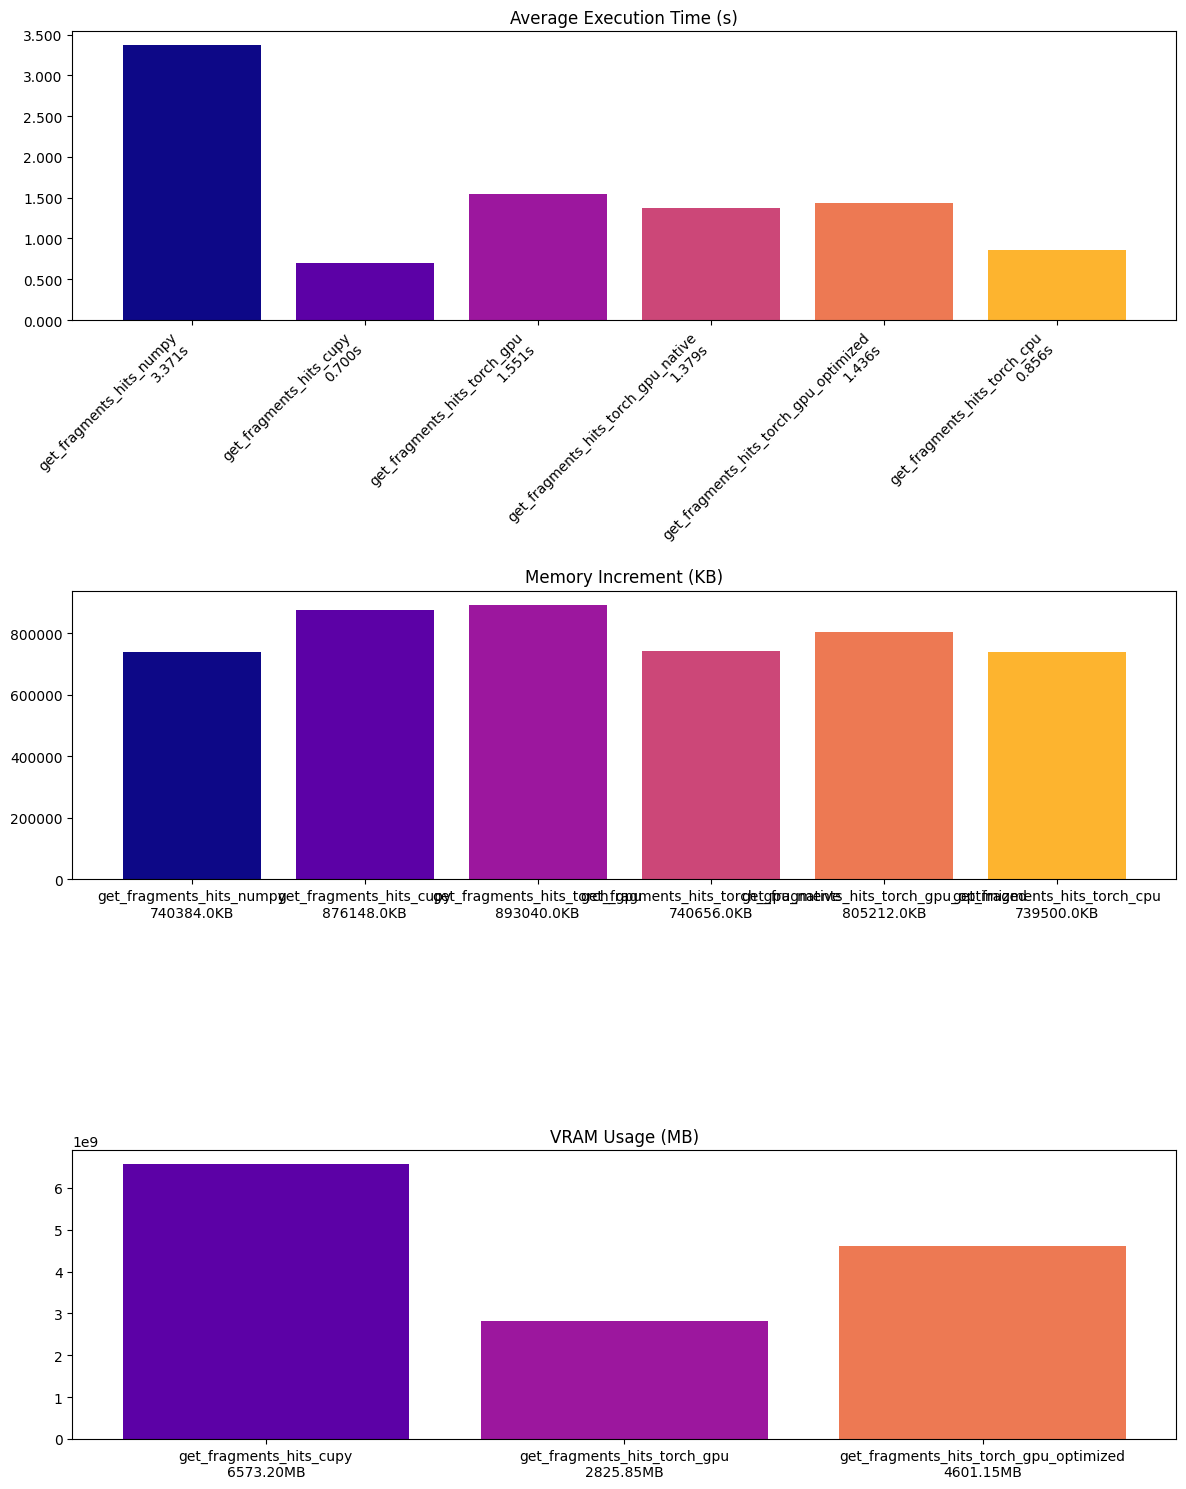

In [5]:
monitor.show_results()